In [1]:
import os

import wave
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt


from IPython.display import Audio

import librosa
import librosa.display

import resampy


from tensorflow.keras.models import Sequential, Model, load_model

from tensorflow.keras.layers import Conv1D, Conv2D, SeparableConv1D, MaxPooling1D, MaxPooling2D
from tensorflow.keras.layers import Input, add, Flatten, Dense, BatchNormalization, Dropout, LSTM, GRU
from tensorflow.keras.layers import GlobalMaxPooling1D, GlobalMaxPooling2D, Activation, LeakyReLU, ReLU

# from tensorflow.keras.layers import Embedding,LSTM,GRU,Dense,MaxPooling1D,Dropout, Input
# from tensorflow.keras.layers import LeakyReLU,ReLU,Flatten,concatenate,Bidirectional,TimeDistributed 
# from tensorflow.keras.layers import add,Conv1D,SeparableConv1D, GlobalMaxPooling2D,GlobalMaxPooling1D
# from tensorflow.keras.layers import Conv2D,Input,Activation,BatchNormalization,MaxPooling2D

from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,matthews_corrcoef
from sklearn.metrics import cohen_kappa_score,roc_auc_score,confusion_matrix,classification_report

In [2]:
audio_data = '/Users/pranavvijitharan/Downloads/WTH 2024/Respiratory Sound Database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/'
patient_data=pd.read_csv('/Users/pranavvijitharan/Downloads/WTH 2024/Respiratory Sound Database/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv',names=['pid','disease'])
diagnosis_df = pd.read_csv('/Users/pranavvijitharan/Downloads/WTH 2024/Respiratory Sound Database/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv', names=['patient_id', 'disease'])
diagnosis_df.head(4)

,patient_id,disease
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD


In [3]:
print (diagnosis_df.disease.value_counts())
print ('')
print (diagnosis_df.disease.value_counts(normalize=True) *100)

disease
COPD              64
Healthy           26
URTI              14
Bronchiectasis     7
Pneumonia          6
Bronchiolitis      6
LRTI               2
Asthma             1
Name: count, dtype: int64

disease
COPD              50.793651
Healthy           20.634921
URTI              11.111111
Bronchiectasis     5.555556
Pneumonia          4.761905
Bronchiolitis      4.761905
LRTI               1.587302
Asthma             0.793651
Name: proportion, dtype: float64


In [4]:
path='/Users/pranavvijitharan/Downloads/WTH 2024/Respiratory Sound Database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files'
files=[s.split('.')[0] for s in os.listdir(path) if '.txt' in s]

In [5]:
files[:10]

['148_1b1_Al_sc_Meditron',
 '130_3p2_Tc_mc_AKGC417L',
 '107_2b4_Al_mc_AKGC417L',
 '160_2b4_Pr_mc_AKGC417L',
 '174_1p4_Ar_mc_AKGC417L',
 '114_1b4_Pl_mc_AKGC417L',
 '138_1p2_Ll_mc_AKGC417L',
 '130_3b4_Lr_mc_AKGC417L',
 '141_1b2_Tc_mc_LittC2SE',
 '193_1b4_Lr_mc_AKGC417L']

In [6]:
def add_noise(data,x):
    noise = np.random.randn(len(data))
    data_noise = data + x * noise
    return data_noise

def shift(data,x):
    return np.roll(data, x)

def stretch(data, rate):
    data = librosa.effects.time_stretch(data, rate=1.0)
    return data

def pitch_shift (data , rate):
    data = librosa.effects.pitch_shift(data, sr=220250, n_steps=rate)
    return data

In [7]:
def show_audio(audio_path):
    y, sr = librosa.load(audio_path)
    y_noise = add_noise(y , 0.0008)
    y_shift = shift(y,3200)
    y_stretch_1 = stretch(y, 1.2)
    y_stretch_2 = stretch(y, 0.8)
    y_pitch_shift = pitch_shift(y, 3)
    
    plt.figure(figsize=(20, 8))
    
    plt.subplot(3,2,1)
    librosa.display.waveshow(y, sr=sr)
    plt.title('orginal')

    plt.subplot(3,2,2)
    librosa.display.waveshow(y_noise, sr=sr)
    plt.title('noise')

    plt.subplot(3,2,3)
    librosa.display.waveshow(y_shift, sr=sr)
    plt.title('shift')
    
    plt.subplot(3,2,4)
    librosa.display.waveshow(y_stretch_1, sr=sr)
    plt.title('stretch 1')
    
    plt.subplot(3,2,5)
    librosa.display.waveshow(y_stretch_2, sr=sr)
    plt.title('stretch 2')
    
    plt.subplot(3,2,6)
    librosa.display.waveshow(y_pitch_shift, sr=sr)
    plt.title('pitch shift')

    plt.tight_layout()

In [8]:
def show_audio_features(audio_path):
    y, sr = librosa.load(audio_path)
    y_noise = add_noise(y , 0.0008)
    y_shift = shift(y,3200)
    y_stretch_1 = stretch(y, 1.2)
    y_stretch_2 = stretch(y, 0.8)
    y_pitch_shift = pitch_shift(y, 3)
    
    y = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=50)
    y_noise = librosa.feature.mfcc(y=y_noise, sr=sr, n_mfcc=50)
    y_shift = librosa.feature.mfcc(y=y_shift, sr=sr, n_mfcc=50)
    y_stretch_1 = librosa.feature.mfcc(y=y_stretch_1, sr=sr, n_mfcc=50)
    y_stretch_2 = librosa.feature.mfcc(y=y_stretch_2, sr=sr, n_mfcc=50)
    y_pitch_shift = librosa.feature.mfcc(y=y_pitch_shift, sr=sr, n_mfcc=50)
    
    plt.figure(figsize=(20, 8))
    
    plt.subplot(3,2,1)
    librosa.display.specshow(librosa.power_to_db(y,ref=np.max),
                             y_axis='mel',
                             fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('orginal')

    plt.subplot(3,2,2)
    librosa.display.specshow(librosa.power_to_db(y_noise,ref=np.max),
                             y_axis='mel',
                             fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('noise')

    plt.subplot(3,2,3)
    librosa.display.specshow(librosa.power_to_db(y_shift,ref=np.max),
                             y_axis='mel',
                             fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('shift')
    
    plt.subplot(3,2,4)
    librosa.display.specshow(librosa.power_to_db(y_stretch_1,ref=np.max),
                             y_axis='mel',
                             fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('stretch 1')
    
    plt.subplot(3,2,5)
    librosa.display.specshow(librosa.power_to_db(y_stretch_2,ref=np.max),
                             y_axis='mel',
                             fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('stretch 2')
    
    plt.subplot(3,2,6)
    librosa.display.specshow(librosa.power_to_db(y_pitch_shift,ref=np.max),
                             y_axis='mel',
                             fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('pitch shift')
    
    

    plt.tight_layout()

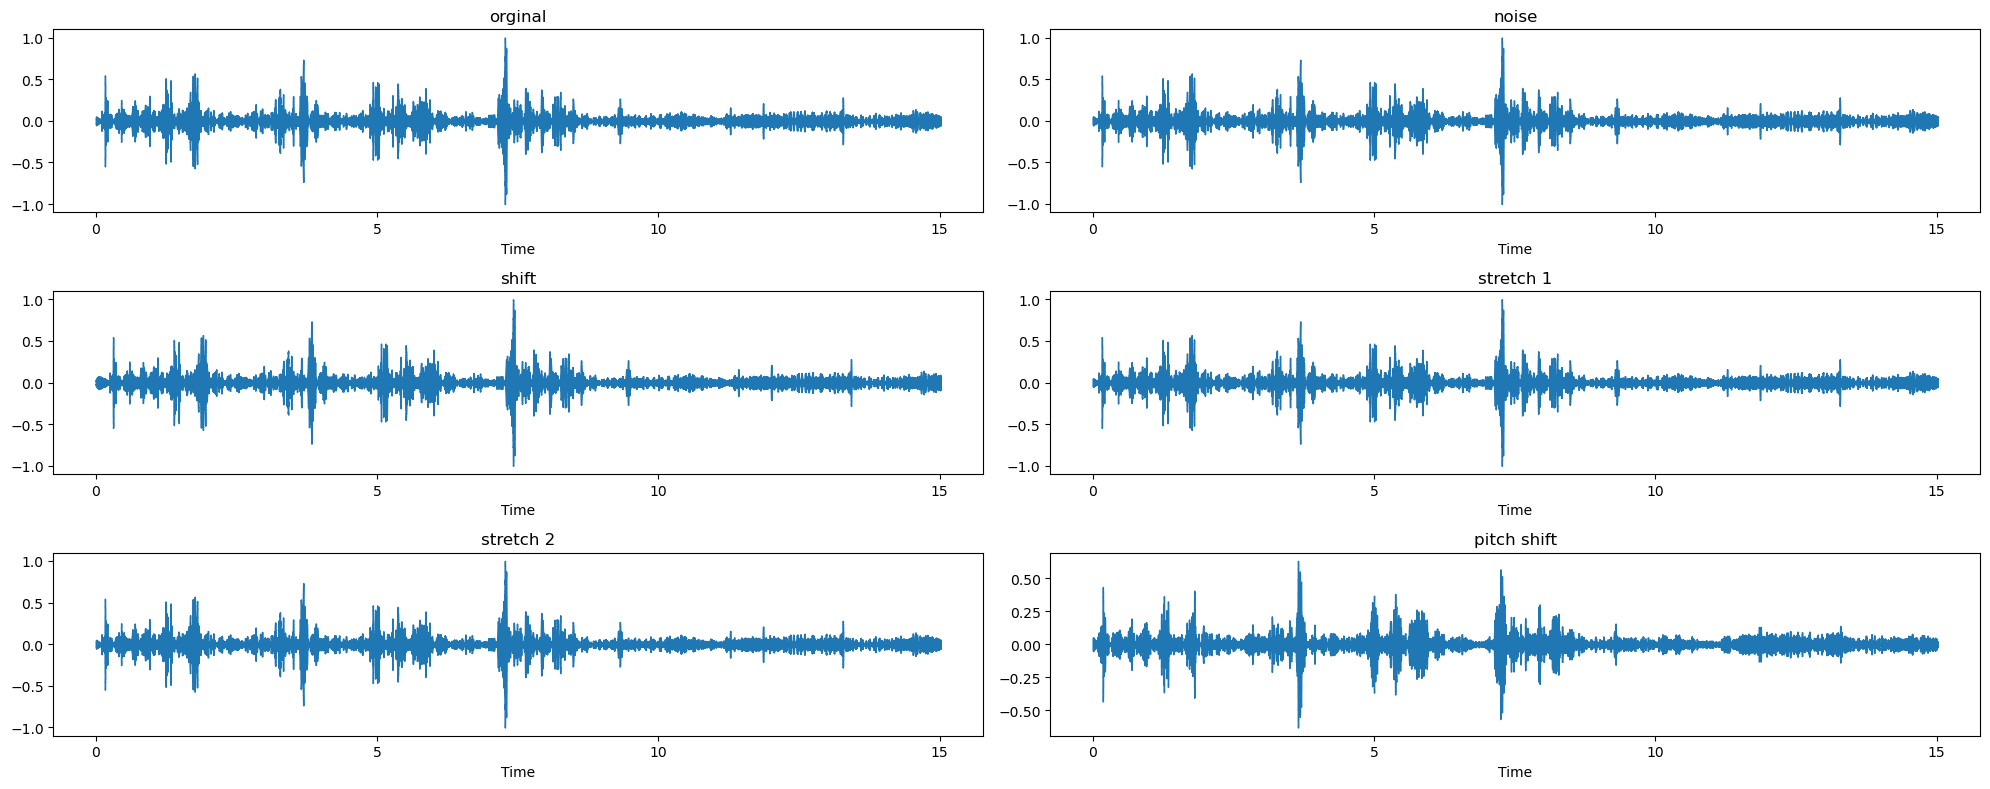

In [9]:
show_audio('/Users/pranavvijitharan/Downloads/WTH 2024/Respiratory Sound Database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/104_1b1_Lr_sc_Litt3200.wav')

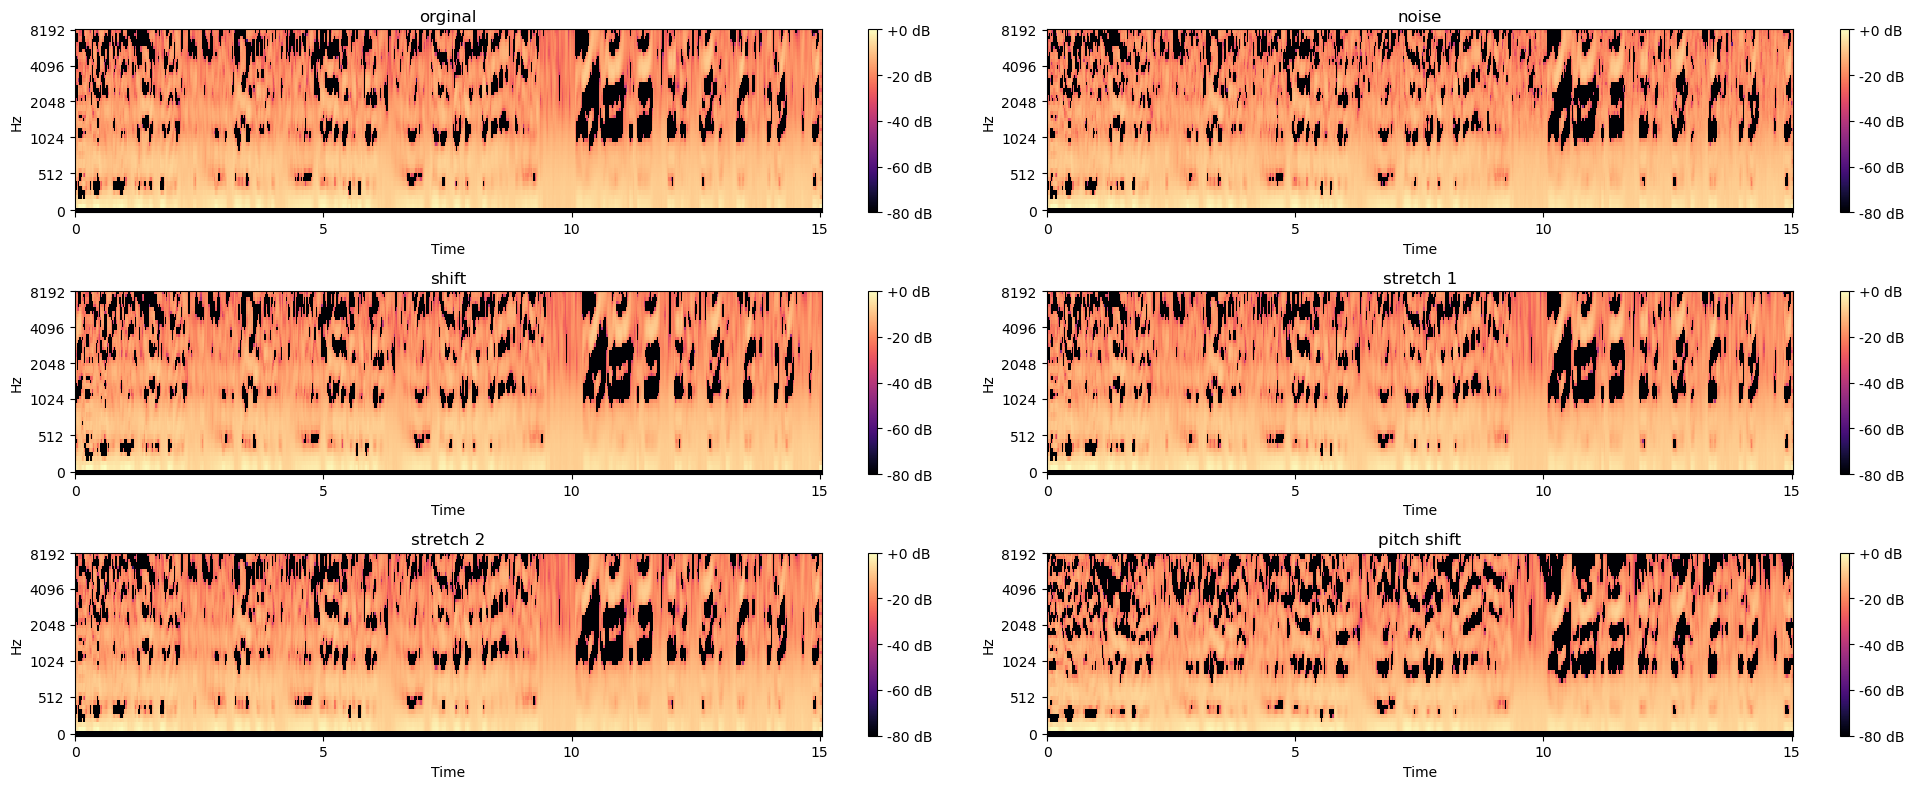

In [10]:
show_audio_features('/Users/pranavvijitharan/Downloads/WTH 2024/Respiratory Sound Database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/104_1b1_Lr_sc_Litt3200.wav')

In [11]:
def mfccs_feature_exteraction(dir_):
    X_=[]
    y_=[]
    
    COPD=[]
    copd_count=0
    
    data = diagnosis_df
    features = 52
    
    for soundDir in (os.listdir(dir_)):
        if soundDir[-3:]=='wav'and soundDir[:3]!='103'and soundDir[:3]!='108'and soundDir[:3]!='115':

            p = list(data[data['patient_id']==int(soundDir[:3])]['disease'])[0]
            if (p=='COPD'):
                if (soundDir[:6] in COPD) and copd_count<2:
                    data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
                    mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    COPD.append(soundDir[:6])
                    copd_count+=1
                    X_.append(mfccs)
                    y_.append(list(data[data['patient_id']==int(soundDir[:3])]['disease'])[0])
                    
                if (soundDir[:6] not in COPD):
                    data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
                    mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    COPD.append(soundDir[:6])
                    copd_count=0
                    X_.append(mfccs)
                    y_.append(list(data[data['patient_id']==int(soundDir[:3])]['disease'])[0])
                
            if (p!='COPD'):
                if ((p == 'Bronchiectasis') or (p == 'Bronchiolitis')):
                    data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
                    mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs)
                    y_.append('Bronchiolitis')
            
                    data_noise = add_noise(data_x,0.001)
                    mfccs_noise = np.mean(librosa.feature.mfcc(y=data_noise, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_noise)
                    y_.append('Bronchiolitis')

                    data_shift = shift(data_x,1600)
                    mfccs_shift = np.mean(librosa.feature.mfcc(y=data_shift, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_shift)
                    y_.append('Bronchiolitis')
                    
                    data_stretch = stretch(data_x,1.2)
                    mfccs_stretch = np.mean(librosa.feature.mfcc(y=data_stretch, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_stretch)
                    y_.append('Bronchiolitis')
                    
                    data_stretch_2 = stretch(data_x,0.8)
                    mfccs_stretch_2 = np.mean(librosa.feature.mfcc(y=data_stretch_2, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_stretch_2)
                    y_.append('Bronchiolitis')
                    
                    data_pitch_shift = pitch_shift(data_x,3)
                    mfccs_stretch = np.mean(librosa.feature.melspectrogram(y=data_pitch_shift, sr=sampling_rate, n_mels=features).T,axis=0)
                    X_.append(mfccs_stretch)
                    y_.append('Bronchiolitis')
                    
                else: 
                    data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
                    mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs)
                    y_.append(list(data[data['patient_id']==int(soundDir[:3])]['disease'])[0])
            
                    data_noise = add_noise(data_x,0.001)
                    mfccs_noise = np.mean(librosa.feature.mfcc(y=data_noise, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_noise)
                    y_.append(p)

                    data_shift = shift(data_x,1600)
                    mfccs_shift = np.mean(librosa.feature.mfcc(y=data_shift, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_shift)
                    y_.append(p)
                    
                    data_stretch = stretch(data_x,1.2)
                    mfccs_stretch = np.mean(librosa.feature.mfcc(y=data_stretch, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_stretch)
                    y_.append(p)
                    
                    data_stretch_2 = stretch(data_x,0.8)
                    mfccs_stretch_2 = np.mean(librosa.feature.mfcc(y=data_stretch_2, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_stretch_2)
                    y_.append(p)
                    
                    data_pitch_shift = pitch_shift(data_x,3)
                    mfccs_stretch = np.mean(librosa.feature.melspectrogram(y=data_pitch_shift, sr=sampling_rate, n_mels=features).T,axis=0)
                    X_.append(mfccs_stretch)
                    y_.append(p)
                    
                    
                
    X_data = np.array(X_)
    y_data = np.array(y_)

    
    return X_data, y_data 

In [12]:
x_mfccs, y = mfccs_feature_exteraction(audio_data)

In [13]:
def augmented_lables_count(lables):
    unique, counts = np.unique(lables, return_counts=True)
    data_count = dict(zip(unique, counts))

    data = data_count

    courses = list(data.keys())
    values = list(data.values())

    fig = plt.figure(figsize = (10, 5))

    # creating the bar plot
    plt.bar(courses, values, color =['orange','green','blue','red','yellow','black'],
            width = 0.4)

    plt.xlabel("Diseases")
    plt.ylabel("Count")
    plt.title("Count of each disease")
    plt.show()

    print (data_count)

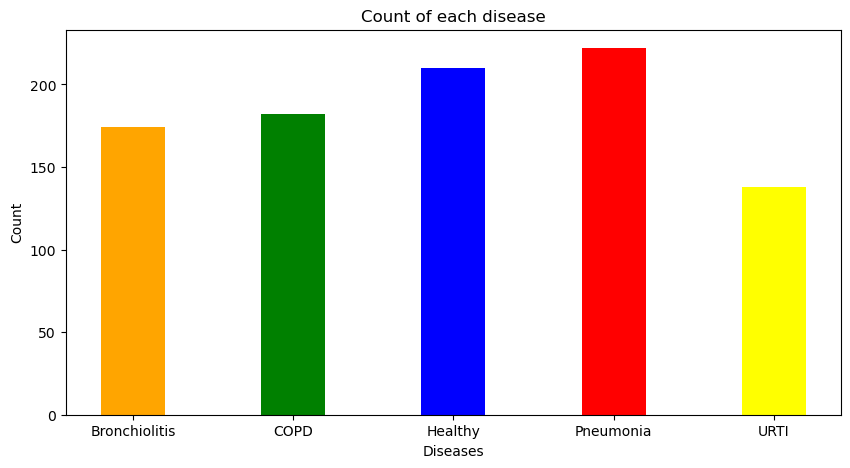

{'Bronchiolitis': 174, 'COPD': 182, 'Healthy': 210, 'Pneumonia': 222, 'URTI': 138}


In [14]:
augmented_lables_count(y)

In [15]:
y_data_encode = y.reshape(y.shape[0],1)
y_data_encode = np.where(y_data_encode == 'COPD',np.array([1,0,0,0,0]).reshape(1,5) , y_data_encode)
y_data_encode = np.where(y_data_encode == 'Bronchiolitis',np.array([0,1,0,0,0]).reshape(1,5) , y_data_encode)
y_data_encode = np.where(y_data_encode == 'Pneumonia',np.array([0,0,1,0,0]).reshape(1,5) , y_data_encode)
y_data_encode = np.where(y_data_encode == 'URTI',np.array([0,0,0,1,0]).reshape(1,5) , y_data_encode)
y_data_encode = np.where(y_data_encode == 'Healthy',np.array([0,0,0,0,1]).reshape(1,5) , y_data_encode)

Y_data = y_data_encode.astype('float64')

In [16]:
mfccs_features = np.array(x_mfccs)
lables = np.array(Y_data)

mfccs_features.shape , lables.shape

((926, 52), (926, 5))

In [17]:
mfcc_train, mfcc_val, lables_train, lables_val  = train_test_split(mfccs_features, lables, test_size=0.175, random_state=10)
mfcc_train, mfcc_test, lables_train, lables_test = train_test_split(mfcc_train, lables_train, test_size=0.075, random_state=10)

print (mfcc_train.shape, mfcc_val.shape, mfcc_test.shape)
print (lables_train.shape, lables_val.shape, lables_test.shape)

(705, 52) (163, 52) (58, 52)
(705, 5) (163, 5) (58, 5)


In [18]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot accuracy
  plt.figure()
  plt.grid()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [19]:
x_train_gru = np.expand_dims(mfcc_train,axis=1)
x_val_gru = np.expand_dims(mfcc_val,axis=1)
x_test_gru = np.expand_dims(mfcc_test,axis=1)

y_train_gru = np.expand_dims(lables_train,axis=1)
y_val_gru = np.expand_dims(lables_val,axis=1)
y_test_gru = np.expand_dims(lables_test,axis=1)

In [20]:
Input_Sample = Input(shape=(1,52))

model_conv = Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu')(Input_Sample)
model_conv = MaxPooling1D(pool_size=2, strides = 2, padding = 'same')(model_conv)
model_conv = BatchNormalization()(model_conv)

model_conv = Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu')(model_conv)
model_conv = MaxPooling1D(pool_size=2, strides = 2, padding = 'same')(model_conv)
model_conv = BatchNormalization()(model_conv)

model_2_1 = GRU(32,return_sequences=True,activation='tanh',go_backwards=True)(model_conv)
model_2 = GRU(128,return_sequences=True, activation='tanh',go_backwards=True)(model_2_1)

model_3 = GRU(64,return_sequences=True,activation='tanh',go_backwards=True)(model_conv)
model_3 = GRU(128,return_sequences=True, activation='tanh',go_backwards=True)(model_3)

model_x = GRU(64,return_sequences=True,activation='tanh',go_backwards=True)(model_conv)
model_x = GRU(128,return_sequences=True, activation='tanh',go_backwards=True)(model_x)

model_add_1 = add([model_3,model_2,model_x])

model_5 = GRU(128,return_sequences=True,activation='tanh',go_backwards=True)(model_add_1)
model_5 = GRU(32,return_sequences=True, activation='tanh',go_backwards=True)(model_5)

model_6 = GRU(64,return_sequences=True,activation='tanh',go_backwards=True)(model_add_1)
model_6 = GRU(32,return_sequences=True, activation='tanh',go_backwards=True)(model_6)

model_add_2 = add([model_5,model_6,model_2_1])


model_7 = Dense(32, activation=None)(model_add_2)
model_7 = LeakyReLU()(model_7)
model_7 = Dense(128, activation=None)(model_7)
model_7 = LeakyReLU()(model_7)

model_9 = Dense(64, activation=None)(model_add_2)
model_9 = LeakyReLU()(model_9)
model_9 = Dense(128, activation=None)(model_9)
model_9 = LeakyReLU()(model_9)

model_add_3 = add([model_7,model_9])

model_10 = Dense(64, activation=None)(model_add_3)
model_10 = LeakyReLU()(model_10)

model_10 = Dense(32, activation=None)(model_10)
model_10 = LeakyReLU()(model_10)

model_10 = Dense(5, activation="softmax")(model_10)

gru_model = Model(inputs=Input_Sample, outputs = model_10)

gru_model.summary()

Metal device set to: Apple M3 Pro

systemMemory: 18.00 GB
maxCacheSize: 6.00 GB



2024-12-20 13:33:13.419816: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-20 13:33:13.419954: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1, 52)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 1, 256)       66816       ['input_1[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 1, 256)       0           ['conv1d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 1, 256)      1024        ['max_pooling1d[0][0]']          
 alization)                                                                                   

In [21]:
print(gru_model.input_shape)

(None, 1, 52)


In [22]:
optimiser = tf.keras.optimizers.Adam(learning_rate = 0.0001)
gru_model.compile(optimizer=optimiser, loss='categorical_crossentropy',metrics=['accuracy'])

cb = [EarlyStopping(patience=300,monitor='accuracy',mode='max',restore_best_weights=True),
      ModelCheckpoint("diagnosis_GRU_CNN_1.h5",save_best_only=True)]

In [46]:
history = gru_model.fit(x_train_gru, y_train_gru, batch_size=8, epochs=800, validation_data=(x_val_gru, y_val_gru), callbacks = cb)

Epoch 1/800


2024-12-19 23:07:10.749970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-12-19 23:07:12.282883: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-12-19 23:07:12.295905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-12-19 23:07:12.310184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-12-19 23:07:12.368734: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-12-19 23:07:12.403785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-12-19 23:07:12.433849: I tensorflow/core/grappler/optimizers/cust

89/89 [==============================] - ETA: 0s - loss: 1.2247 - accuracy: 0.5177

2024-12-19 23:07:19.817063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-12-19 23:07:20.364321: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-12-19 23:07:20.373784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-12-19 23:07:20.384534: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-12-19 23:07:20.467350: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-12-19 23:07:20.489655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-12-19 23:07:20.513333: I tensorflow/core/grappler/optimizers/cust

89/89 [==============================] - 16s 88ms/step - loss: 1.2247 - accuracy: 0.5177 - val_loss: 1.3260 - val_accuracy: 0.5951
Epoch 2/800
89/89 [==============================] - 5s 56ms/step - loss: 1.0591 - accuracy: 0.6099 - val_loss: 1.1615 - val_accuracy: 0.6074
Epoch 3/800
89/89 [==============================] - 5s 56ms/step - loss: 0.9678 - accuracy: 0.6241 - val_loss: 0.9428 - val_accuracy: 0.6871
Epoch 4/800
89/89 [==============================] - 5s 57ms/step - loss: 0.9121 - accuracy: 0.6270 - val_loss: 0.8448 - val_accuracy: 0.6871
Epoch 5/800
89/89 [==============================] - 5s 56ms/step - loss: 0.8529 - accuracy: 0.6426 - val_loss: 0.7862 - val_accuracy: 0.7178
Epoch 6/800
89/89 [==============================] - 5s 56ms/step - loss: 0.8580 - accuracy: 0.6468 - val_loss: 0.8348 - val_accuracy: 0.6687
Epoch 7/800
89/89 [==============================] - 5s 57ms/step - loss: 0.8257 - accuracy: 0.6582 - val_loss: 0.7022 - val_accuracy: 0.8037
Epoch 8/800
89/89

23/23 [==============================] - 2s 49ms/step - loss: 0.1390 - accuracy: 0.9518


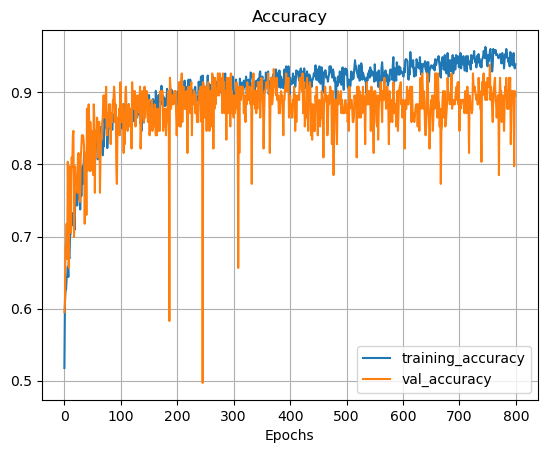

In [47]:
gru_model.evaluate(x_train_gru, y_train_gru)

plot_loss_curves(history)

In [23]:
gru_model.load_weights('diagnosis_GRU_CNN_1.h5')

2024-12-20 13:33:14.869694: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-12-20 13:33:15.899803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-12-20 13:33:16.447453: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-12-20 13:33:16.456370: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-12-20 13:33:16.467111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-12-20 13:33:16.544263: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-12-20 13:33:16.580360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113

2/2 [==============================] - 2s 259ms/step


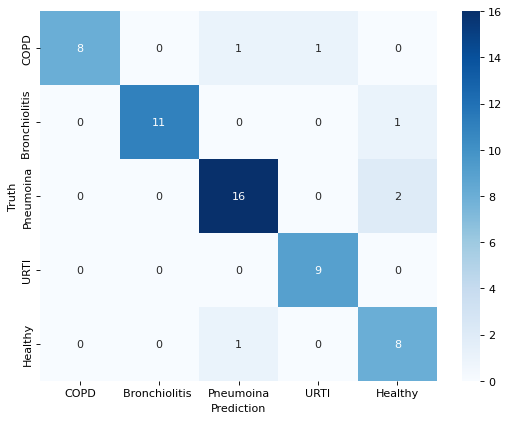

In [24]:
classes = ["COPD" ,"Bronchiolitis ", "Pneumoina", "URTI", "Healthy"]

preds = gru_model.predict(x_test_gru)
classpreds = [np.argmax(t) for t in preds ]
y_testclass = [np.argmax(t) for t in y_test_gru]
cm = confusion_matrix(y_testclass, classpreds)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(cm, cmap='Blues', annot=True, fmt='d', xticklabels=classes, yticklabels=classes)

plt.title('')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [25]:
print(classification_report(y_testclass, classpreds, target_names=classes))

                precision    recall  f1-score   support

          COPD       1.00      0.80      0.89        10
Bronchiolitis        1.00      0.92      0.96        12
     Pneumoina       0.89      0.89      0.89        18
          URTI       0.90      1.00      0.95         9
       Healthy       0.73      0.89      0.80         9

      accuracy                           0.90        58
     macro avg       0.90      0.90      0.90        58
  weighted avg       0.91      0.90      0.90        58



In [26]:
val=[]
dir_= '/Users/pranavvijitharan/Downloads/WTH 2024/Respiratory Sound Database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/125_1b1_Tc_sc_Meditron.wav'
features = 52

data_x, sampling_rate = librosa.load(dir_,res_type='kaiser_fast')
mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis=0)
val.append(mfccs)
val = np.expand_dims(val,axis=1)

In [27]:
classes[np.argmax(gru_model.predict(val))]

1/1 [==============================] - 0s 353ms/step


'Healthy'

In [28]:
x_test_gru[0]

array([[-3.93255648e+02,  8.21288368e+01,  3.70402331e+01,
         1.16557893e+01,  1.37218012e+01,  2.38859297e+01,
         2.14925733e+01,  1.42355374e+01,  9.71822558e+00,
         1.25363581e+01,  1.53603409e+01,  1.19768097e+01,
         8.34209030e+00,  7.04131251e+00,  7.78223144e+00,
         7.60821758e+00,  5.01563647e+00,  4.51672526e+00,
         4.06574823e+00,  5.32182062e+00,  4.94905103e+00,
         3.38721958e+00,  3.35494795e+00,  2.42724585e+00,
         3.09619809e+00,  2.28567708e+00,  2.22076571e+00,
         3.02630321e+00,  2.56568916e+00,  2.91838526e+00,
         1.93817066e+00,  1.72845015e+00,  1.33962022e+00,
         8.06765872e-01,  1.58085737e+00,  1.26716341e+00,
         1.26190197e+00,  1.07321492e+00,  7.14543218e-01,
         1.63319231e+00,  9.65586250e-01,  1.06843931e+00,
         7.06141681e-01,  5.05289229e-01,  1.43030822e+00,
         6.28967260e-01,  1.30821054e+00,  8.10372948e-01,
         5.01906621e-01,  6.68474012e-01,  2.72946749e-0

In [29]:
x_test_gru.shape

(58, 1, 52)

In [30]:
y_test_gru[0]

array([[0., 0., 0., 0., 1.]])

In [31]:
y_test_gru.shape

(58, 1, 5)

### ORIGINAL TF MODEL

In [32]:
tf_output = gru_model(x_test_gru[6].reshape(1, 1, 52))
output_array = tf_output.numpy()
predicted_class = np.argmax(output_array, axis=-1)
print("TF model output:", output_array)
print("Predicted class index:", predicted_class+1)

TF model output: [[[1.8072955e-06 9.9998522e-01 3.0430781e-06 3.5056761e-08 9.8928122e-06]]]
Predicted class index: [[2]]


### TF-LITE WITHOUT QUANTIZATION

In [33]:
converter = tf.lite.TFLiteConverter.from_keras_model(gru_model)
converter.experimental_enable_resource_variables = True
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]
converter._experimental_lower_tensor_list_ops = True  

tflmodel = converter.convert()
file1 = open("model.tflite","wb")
file1.write(tflmodel)

INFO:tensorflow:Assets written to: /var/folders/w_/kxzxj71x1bvc0mxtbb44ptzw0000gn/T/tmp8wzcyb6c/assets


INFO:tensorflow:Assets written to: /var/folders/w_/kxzxj71x1bvc0mxtbb44ptzw0000gn/T/tmp8wzcyb6c/assets
2024-12-20 13:33:52.131405: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2024-12-20 13:33:52.131434: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2024-12-20 13:33:52.132016: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/w_/kxzxj71x1bvc0mxtbb44ptzw0000gn/T/tmp8wzcyb6c
2024-12-20 13:33:52.189121: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2024-12-20 13:33:52.189143: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: /var/folders/w_/kxzxj71x1bvc0mxtbb44ptzw0000gn/T/tmp8wzcyb6c
2024-12-20 13:33:52.391696: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2024-12-20 13:33:52.434368: I tensorflow/cc/saved_model/load

ConverterError: /Users/pranavvijitharan/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/saved_model/save.py:1325:0: error: 'tf.TensorListReserve' op requires element_shape to be static during TF Lite transformation pass
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall"]): called from
/Users/pranavvijitharan/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/saved_model/save.py:1325:0: error: failed to legalize operation 'tf.TensorListReserve' that was explicitly marked illegal
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall"]): called from
<unknown>:0: error: Lowering tensor list ops is failed. Please consider using Select TF ops and disabling `_experimental_lower_tensor_list_ops` flag in the TFLite converter object. For example, converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]\n converter._experimental_lower_tensor_list_ops = False


In [37]:
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

test_input = x_test_gru[6].reshape(1, 1, 52)  
test_input = test_input.astype(np.float32) 

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

interpreter.set_tensor(input_details[0]['index'], test_input)
interpreter.invoke()

output_data = interpreter.get_tensor(output_details[0]['index'])
predicted_class = np.argmax(output_data, axis=-1)

print("TFLite model output:", output_data)
print("Predicted class index:", predicted_class+1)

TFLite model output: [[[1.8072953e-06 9.9998522e-01 3.0430754e-06 3.5056626e-08 9.8928112e-06]]]
Predicted class index: [[2]]


INFO: Created TensorFlow Lite delegate for select TF ops.
2024-12-20 08:53:52.518137: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-20 08:53:52.518269: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
INFO: TfLiteFlexDelegate delegate: 26 nodes delegated out of 197 nodes with 14 partitions.



### TF-LITE WITH QUANTIZATION

In [ ]:
interpreter = tf.lite.Interpreter(model_path="model_quantized.tflite")
interpreter.allocate_tensors()

test_input = x_test_gru[6].reshape(1, 1, 52)  # Reshape the first row to match model input shape
test_input = (test_input).astype(np.int8)  # Normalize for quantization

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

interpreter.set_tensor(input_details[0]['index'], test_input)

interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
print("Output:", output_data)

Output: [[[-128 -125 -128  125 -128]]]


2024-12-20 02:36:58.414663: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-20 02:36:58.414703: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
